In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import scipy.stats as stats
import scipy.integrate as integrate
import pymc3 as pm
from random import choices
import pickle
scale90=stats.norm.interval(.9)[1]
#%matplotlib notebook
import seaborn as sns
sns.set_style("whitegrid")
from scipy.interpolate import interp1d
import arviz as az

In [2]:
lams=np.linspace(-5,5,1000)
alphas=np.linspace(-1,1,500)
Ses=np.linspace(0,10,100)

lamshape=len(lams)
alphashape=len(alphas)

def PnegF2(F):
    
    muF= - 4.0
    sigF=0.49/1.64

    #muT=-5.
    #sigT=1.
    return np.exp(-0.5*(F-muF)**2/sigF**2)*1/(np.sqrt(2*np.pi)*sigF)

def normlam(X,x=lams):
    return X/np.trapz(X,x=x)

def lam_to_S(lambda_pdf,debug=False):
    S_results=[]
    interp_lam=interp1d(lams, lambda_pdf, kind='cubic',fill_value=0,bounds_error=False)
    for S in Ses:
        if debug:
            print(S)
        integrand=lambda L: PnegF2(S*L)*interp_lam(L)* np.abs(L)

        S_results+=[integrate.quad(integrand,-np.inf,np.inf)[0]]
    return np.array(S_results)

# Observations of the Last Glacial Maximum
The uncertainty comes from uncertainty in the "true" value of $\Delta T$ and $\Delta F$.  Here, I will model them as the Tierney estimate
$$P_(\Delta T)(\Delta T) \sim \mathcal{N}(-6.1,0.49)$$ 
and the estimate of radiative forcing from the WCRP assessment 
$$P_(\Delta F) (\Delta F) \sim \mathcal{N}(-8.8,2)$$
Moving forward, I believe the best thing to do is to use a hierarchical model for these quantities.  Both the "true" temperature difference and forcing change are unobservable.  Instead, we have an ensemble of reconstructed temperatures and observationally-constrained modeled radiative forcing.  How should we combine these to get a best estimate of LGM temperature and forcing?  I think the best (at least simplest) way to do this is to treat each estimate as drawn from a distribution with unknown mean and standard deviation.  We can put priors on this distribution:
$$\mu | \sigma \sim \mathcal{N}(\mu_0,\sigma/\sqrt{\nu})$$
and
$$\sigma^2 \sim IG(k, 1/\sigma_0^2)$$
The posteriors will therefore depend on our prior beliefs in the "true" underlying value of these quantities: 

In [3]:
def get_tierney_forcing(nsamp_big=10000):
    muGHG=-2.48
    sigmaGHG=0.15

    #ice sheet https://royalsocietypublishing.org/doi/full/10.1098/rsta.2014.0424#d3e824
    #are error bars 1 or 2 sigma?!?!
    nsamp=1000
    pmip3_means=[-3.79,-4.9,-5.2,-4.57,-3.62]
    pmip2_means=[-2.59,-2.66,-3.23,-3.41,-3.48,-2.88]
    tierney_2020_mean=[-3.29]
    pmip3_sigmas=[0.1,0.1,0.3,0.3,0.1]
    pmip2_sigmas=np.tile(0.1,len(pmip2_means)).tolist()
    tierney_2020_sigma=[0.1]

    ice_means=pmip3_means+pmip2_means+tierney_2020_mean
    ice_sigmas=pmip3_sigmas+pmip2_sigmas+tierney_2020_sigma
    Rice=np.random.normal(ice_means[0],ice_sigmas[0],nsamp)
    for mu,sig in zip(ice_means[1:],ice_sigmas[1:]):
        Rice=np.append(Rice,np.random.normal(mu,sig,nsamp))


    #dust https://link.springer.com/article/10.1007/s40641-018-0100-7#Tab1
    Rdust=[-2,-1.1,-1,0.,.1,-.1,-.2,-.3,-.5]

    total_forcing=np.random.normal(muGHG,sigmaGHG,nsamp_big)\
    +np.random.choice(ice_means,nsamp_big)\
    +np.random.choice(Rdust,nsamp_big)


    return total_forcing
tierney_forcing=get_tierney_forcing(nsamp_big=10000)
tierney_kde=stats.gaussian_kde(tierney_forcing)

In [4]:
def PT(T,tempfrom="meta"):
    if tempfrom == "tierney":
        muT= -6.1
        sigT=(6.5-5.7)/scale90
    elif tempfrom  == "annan": 
        muT=-5.
        sigT=1.
    else:
        muT=-5.322779058423828
        sigT=0.35107325553725105
    return np.exp(-0.5*(T-muT)**2/sigT**2)*1/(np.sqrt(2*np.pi)*sigT)
def PF(F,tempfrom="meta"):
    if tempfrom=="annan":
        muF=-8.8
        sigF=2.
        return np.exp(-0.5*(F-muF)**2/sigF**2)*1/(np.sqrt(2*np.pi)*sigF)
    elif tempfrom == "tierney": 
        return tierney_kde(F)
    else:
        #from Meta_Analysis.ipynb
        muF=-8.404718846505727
        sigF=0.6054707872650976

        return np.exp(-0.5*(F-muF)**2/sigF**2)*1/(np.sqrt(2*np.pi)*sigF)


## Forcing from Tierney et al 2020
The forcing is drawn from an empirical distribution and is highly non-Gaussian

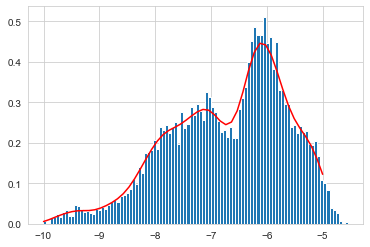

In [5]:
plt.figure()
tmp=plt.hist(tierney_forcing,100,density=True)
plt.plot(np.linspace(-10,-5),tierney_kde(np.linspace(-10,-5)),c="r")

In [6]:
def normT(tempfrom="tierney",nsamp=1000):
    if tempfrom == "tierney":
        muT= -6.1
        sigT=(6.5-5.7)/scale90
    else:
        
        muT=-5.
        sigT=1.
    return np.random.normal(muT,sigT,nsamp)
def normF(nsamp=1000):
    muF=-8.8
    sigF=2.

    #muT=-5.
    #sigT=1.
    return np.random.normal(muF,sigF,nsamp)

In [7]:
#plt.set_cmap(cm.magma)
#plt.figure()
dTsamp=np.linspace(-14,0,100)
dFsamp=np.linspace(-14,0,101)
GaussPlot=np.zeros((len(dTsamp),len(dFsamp)))
for i in range(len(dTsamp)):
    for j in range(len(dFsamp)):
        GaussPlot[i,j]=PT(dTsamp[i],tempfrom="tierney")*PF(dFsamp[j],tempfrom="tierney")
        
GaussPlota=np.zeros((len(dTsamp),len(dFsamp)))
for i in range(len(dTsamp)):
    for j in range(len(dFsamp)):
        GaussPlota[i,j]=PT(dTsamp[i],tempfrom="annan")*PF(dFsamp[j],tempfrom="annan")

In [8]:
import seaborn as sns
sns.set_style("whitegrid")

# Figure 1

# Last Glacial Maximum Likelihood
Let's assume (for now) the pattern effect during the last glacial maxiumum is zero (ie, the pattern effect arises only through diseqilibrium) but that there might be state dependence.  In that case, our model for the climate system is 
\begin{equation}
0 = \lambda \Delta T - 2\alpha \Delta T^2 + \Delta F \label{eq}
\end{equation}
and the likelihood is given by the line integral of the joint PDF over this curve:
$$\mathcal{L}(\lambda,\alpha | \Delta T, \Delta F) = \int_C P_{\Delta T}(\Delta T)  P_{\Delta F}(\Delta F) dl$$
which, given the simple model, is eqivalent to
$$\int_{-\infty}^{+\infty}P_{\Delta T}(x) P_{\Delta F}(2\alpha x^2 -\lambda x) \sqrt{1+(4\alpha x-\lambda)^2} dx$$

In [15]:
def LGM_likelihood(lam,alpha,tempfrom="tierney"):
    
    #integrand=lambda x: PF(2*alpha*x**2- lam*x)*PT(x,tempfrom=tempfrom)* np.sqrt(1+(4*alpha*x-lam)**2)
    integrand=lambda x: PF(-alpha/2.*x**2- lam*x,tempfrom=tempfrom)*PT(x,tempfrom=tempfrom)* np.sqrt(1+(-alpha*x+-lam)**2)

    return integrate.quad(integrand,-np.inf,np.inf)[0]

In [16]:
LGMannan=np.array([LGM_likelihood(x,0,tempfrom="annan") for x in lams])
LGMtierney=np.array([LGM_likelihood(x,0,tempfrom="tierney") for x in lams])

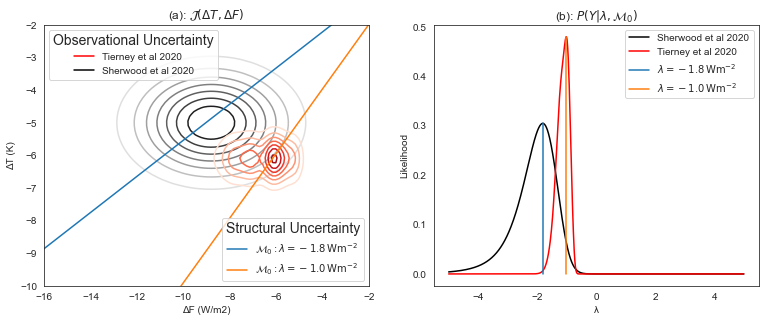

In [95]:
sns.set_style("white")
fig=plt.figure(figsize=(2*6.4, 4.8))
ax=fig.add_subplot(121)
plt.contour(dFsamp,dTsamp,GaussPlota,cmap=cm.gray_r)
x=plt.axhline(-5,c="r",label="Tierney et al 2020")
y=plt.axvline(-5,c="k",label="Sherwood et al 2020")
plt.contour(dFsamp,dTsamp,GaussPlot,cmap=cm.Reds)
plt.xlabel("ΔF (W/m2)")
plt.ylabel("ΔT (K)")


#Plot ERF
lam_val=-1.806806806806807
alpha_val=0
plt.plot(-alpha_val/2.*dTsamp**2-lam_val*dTsamp,dTsamp,label="α=0, λ=-1.8")

lam_val=-1.01
alpha_val=0
plt.plot(-alpha_val/2.*dTsamp**2-lam_val*dTsamp,dTsamp,label="α=0, λ=-1.11")


#plt.legend()
# lam_val=-1.806806806806807
# alpha_val=0
# plt.plot(-alpha_val/2.*dTsamp**2-lam_val*dTsamp,dTsamp,label="α=0, λ=-1.8")

#Plot ERF
# lam_val=-1.806806806806807
# alpha_val=0
# epsilon=0.7
# plt.plot(-lam_val*dTsamp/epsilon,dTsamp,label="ϵ=0.7, λ=-1.3")



# lam_val=-1.0
# alpha_val=0.1
# plt.plot(-alpha_val/2.*dTsamp**2-lam_val*dTsamp,dTsamp,label="α=+0.1, λ=-1.0")
lines=plt.gca().get_lines()

leg1=plt.legend([lines[i] for i in [0,1]],\
           ["Tierney et al 2020", "Sherwood et al 2020"],\
           loc=2,title="Observational Uncertainty",title_fontsize=14)
leg2=plt.legend([lines[i] for i in [2,3]],\
           [r"$\mathcal{M}_0:\lambda=-1.8\, \rm{Wm}^{-2}$ "\
            ,r"$\mathcal{M}_0: \lambda=-1.0\, \rm{Wm}^{-2}$"],#, "ϵ=0.7, λ=-1.8"],\
           loc=4,title="Structural Uncertainty",title_fontsize=14)
x.set_visible(False)
y.set_visible(False)
plt.xlim(-16,-2)
plt.ylim(-10,-2)
plt.gca().add_artist(leg1)
plt.title(r"(a): $\mathcal{J}(\Delta T, \Delta F)$ ")


ax2=fig.add_subplot(122)
plt.plot(lams,LGMannan,c="k",label="Sherwood et al 2020")
plt.plot(lams,LGMtierney,c="r",label="Tierney et al 2020")
plt.plot([-1.806806806806807,-1.806806806806807],[0,np.max(LGMannan)],label=r"$\lambda=-1.8\, \rm{Wm}^{-2}$")
plt.plot([lams[np.argmax(LGMtierney)],lams[np.argmax(LGMtierney)]],[0,np.max(LGMtierney)],label=r"$\lambda=-1.0\, \rm{Wm}^{-2}$")
plt.legend()
plt.xlabel("λ")
plt.ylabel("Likelihood")
plt.title(r"(b): $P(Y|\lambda,\mathcal{M}_0)$")

plt.savefig("FIGS/evidence_model.png")

In [114]:
LGM_alpha_annan=np.zeros((5,len(lams)))
i=0
for a in [-0.1,-0.05,0,0.05,0.1]:
    LGM_alpha_annan[i]=np.array([LGM_likelihood(x,a,tempfrom="annan") for x in lams])
    i+=1
    
LGM_alpha_tierney=np.zeros((5,len(lams)))
i=0
for a in [-0.1,-0.05,0,0.05,0.1]:
    LGM_alpha_tierney[i]=np.array([LGM_likelihood(x,a,tempfrom="tierney") for x in lams])
    i+=1

(-5.0, 0.0)

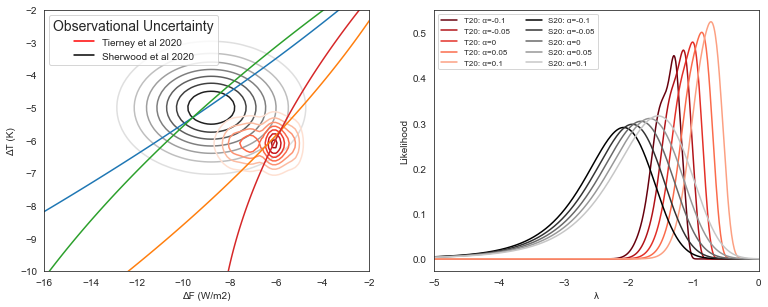

In [94]:
fig=plt.figure(figsize=(2*6.4, 4.8))
ax=fig.add_subplot(121)
plt.contour(dFsamp,dTsamp,GaussPlota,cmap=cm.gray_r)
x=plt.axhline(-5,c="r",label="Tierney et al 2020")
y=plt.axvline(-5,c="k",label="Sherwood et al 2020")
plt.contour(dFsamp,dTsamp,GaussPlot,cmap=cm.Reds)
plt.xlabel("ΔF (W/m2)")
plt.ylabel("ΔT (K)")


#Plot ERF
lam_val=-1.54654655
alpha_val=0.1
plt.plot(-alpha_val/2.*dTsamp**2-lam_val*dTsamp,dTsamp)

lam_val=-0.73573574
alpha_val=0.1
plt.plot(-alpha_val/2.*dTsamp**2-lam_val*dTsamp,dTsamp)

lam_val=-2.07707708
alpha_val=-0.1
plt.plot(-alpha_val/2.*dTsamp**2-lam_val*dTsamp,dTsamp)

lam_val=-1.30630631
alpha_val=-0.1
plt.plot(-alpha_val/2.*dTsamp**2-lam_val*dTsamp,dTsamp)




lines=plt.gca().get_lines()

leg1=plt.legend([lines[i] for i in [0,1]],\
           ["Tierney et al 2020", "Sherwood et al 2020"],\
           loc=2,title="Observational Uncertainty",title_fontsize=14)

x.set_visible(False)
y.set_visible(False)
plt.xlim(-16,-2)
plt.ylim(-10,-2)

plt.subplot(122)
a=[-0.1,-0.05,0,0.05,0.1]
tmp=[plt.plot(lams,LGM_alpha_tierney[i],c=cm.Reds_r(i/6.),label="T20: α="+str(a[i])) for i in range(5)]
tmp=[plt.plot(lams,LGM_alpha_annan[i],c=cm.Greys_r(i/6.),label="S20: α="+str(a[i])) for i in range(5)]
plt.legend(ncol=2,fontsize=8)
plt.xlabel("λ")
plt.ylabel("Likelihood")
plt.xlim(-5,0)

# Prior on $\lambda$
Assume the process evidence gives rise to a prior on $\lambda$:
$$P(\lambda) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left\{-\frac{1}{2}\left(\frac{\lambda-\mu}{\sigma} \right)^2  \right\}$$
with $\mu=-1.3$ and $\sigma = 0.44$ as in the WCRP assessment.

In [19]:
mulam=-1.3
siglam=0.44

proc=np.exp(-0.5*(lams-mulam)**2/siglam**2)*1/(np.sqrt(2*np.pi)*siglam)

# Prior on $\alpha$
This is taken from the WCRP assessment paleo section.  "Most analyses suggest stronger net feedback for glacial
states (i.e., λ more negative, implying a lower sensitivity)."  So the assessment used
$$P(\alpha) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left\{-\frac{1}{2}\left(\frac{\alpha-\mu}{\sigma} \right)^2  \right\}$$
with $\mu=+0.1$ and $\sigma = 0.1$

In [20]:
alphaprior=np.exp(-0.5*(alphas-0.1)**2/(0.1**2))*1/(np.sqrt(2*np.pi)*0.1)

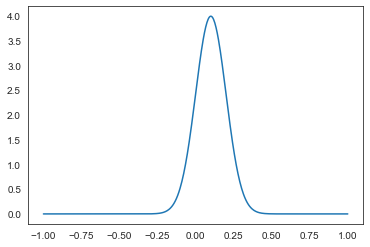

In [21]:
plt.plot(alphas,alphaprior)

# How much does state dependence matter?
Let's calculate the likelihood function for $\lambda$ for the LGM conditional on various values of $\alpha$.

Text(0, 0.5, 'Likelihood')

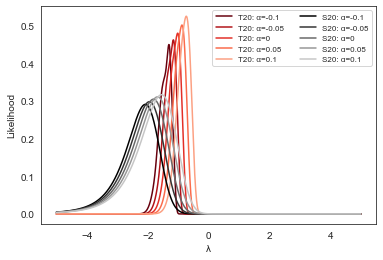

In [37]:
a=[-0.1,-0.05,0,0.05,0.1]
tmp=[plt.plot(lams,LGM_alpha_tierney[i],c=cm.Reds_r(i/6.),label="T20: α="+str(a[i])) for i in range(5)]
tmp=[plt.plot(lams,LGM_alpha_annan[i],c=cm.Greys_r(i/6.),label="S20: α="+str(a[i])) for i in range(5)]
plt.legend(ncol=2,fontsize=8)
plt.xlabel("λ")
plt.ylabel("Likelihood")

In [54]:
lams[np.argmax(LGM_alpha_annan,axis=1)]

array([-2.07707708, -1.94694695, -1.80680681, -1.67667668, -1.54654655])

In [58]:
lams[np.argmax(LGM_alpha_tierney,axis=1)]

array([-1.30630631, -1.15615616, -1.01601602, -0.87587588, -0.73573574])

max likelihood S, alpha=0 2.213850415512465
max likelihood S, alpha=0.1 2.5864077669902916


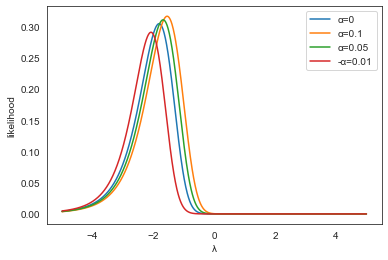

In [23]:
plt.figure()
plt.plot(lams,LGM0,label="α=0")
plt.plot(lams,LGM01,label="α=0.1")
plt.plot(lams,LGM005,label="α=0.05")

plt.plot(lams,LGMneg01,label="-α=0.1")
plt.xlabel("λ")
plt.ylabel("likelihood")
plt.legend()
print("max likelihood S, alpha=0",-4./lams[np.argmax(LGM0)])
print("max likelihood S, alpha=0.1",-4./lams[np.argmax(LGM01)])


In [48]:
print(lams[np.argmax(LGM01)])

-1.5465465465465464


## Joint PDF for LGM
Generate the joint likelihood for various values of $\lambda$ and $\alpha$.  Note that these are not samples- we're just integrating the joint PDF for the temperature and forcing changes over the curve defined by the energy balance model with state dependence.

In [66]:
import datetime


In [67]:
generate_joint_PDF=False
pickle_it=False
if generate_joint_PDF:
    JPDF_tierney=np.zeros((lamshape,alphashape))
    JPDF_annan=np.zeros((lamshape,alphashape))
    for i in range(lamshape):
        for j in range(alphashape):
            JPDF_tierney[i,j]=LGM_likelihood(lams[i],alphas[j],tempfrom="tierney")
            JPDF_annan[i,j]=LGM_likelihood(lams[i],alphas[j],tempfrom="annan")
else:
    with open("PICKLED/LGM_JPDF_tierney_05312022.pkl","rb") as picklefile:
        JPDF_tierney=pickle.load(picklefile)
    with open("PICKLED/LGM_JPDF_annan_05312022.pkl","rb") as picklefile:
        JPDF_annan=pickle.load(picklefile)

if pickle_it:
    today=datetime.date.today().strftime("%m%d%Y")
    with open("PICKLED/LGM_JPDF_tierney_"+today+".pkl","wb") as picklefile:
        pickle.dump(JPDF_tierney,picklefile)
    with open("PICKLED/LGM_JPDF_annan_"+today+".pkl","wb") as picklefile:
        pickle.dump(JPDF_annan,picklefile)

# Uniform priors on all parameters
If we don't know anything about either the feedbacks or the state dependence, large values of alpha are favored.

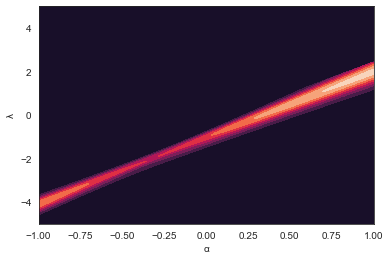

In [69]:
plt.figure()
plt.contourf(alphas,lams,JPDF_tierney)
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

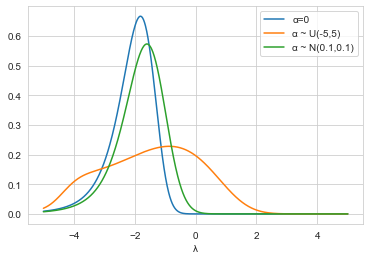

In [52]:
# Marginalizing over alpha with uniform and Gaussian priors
plt.figure()
plt.plot(lams,normlam(LGM0),label="α=0")
plt.plot(lams,normlam(np.sum(JPDF_annan,axis=1)),label="α ~ U(-5,5)")
plt.plot(lams,normlam(np.dot(JPDF_annan,alphaprior)),label="α ~ N(0.1,0.1)")
plt.xlabel("λ")
plt.legend()

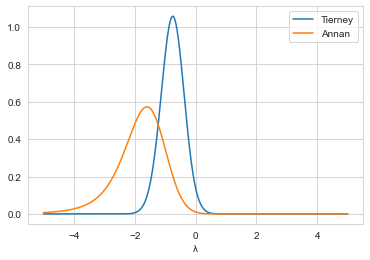

In [53]:
#difference between Tierney and Annan using the same model and same priors (Gaussian on alpha, uniform on lambda)
plt.figure()
plt.plot(lams,normlam(np.dot(JPDF_tierney,alphaprior)),label="Tierney")
plt.plot(lams,normlam(np.dot(JPDF_annan,alphaprior)),label="Annan")
#
plt.xlabel("λ")
plt.legend()

# Marginal PDF of alpha given the process evidence
If we treat the process evidence as a prior on $\lambda$, what does this tell us about the possible values of the state dependence?  And how does this compare to the priors placed on the state dependence in S20?

The process evidence imposes the same constraints on $\lambda$, regardless of $\alpha$

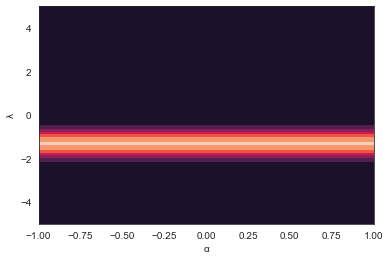

In [71]:
justproc=np.tile(proc,len(alphas)).reshape(len(alphas),len(proc)).T
plt.figure()
plt.contourf(alphas,lams,justproc)
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

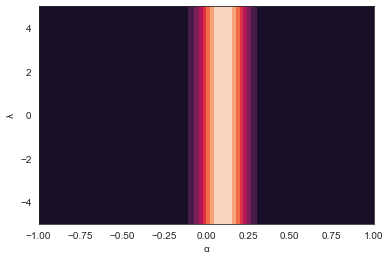

In [72]:
justalpha=np.tile(alphaprior,len(lams)).reshape(len(lams),len(alphas))
plt.figure()
plt.contourf(alphas,lams,justalpha)
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

# Figure 2

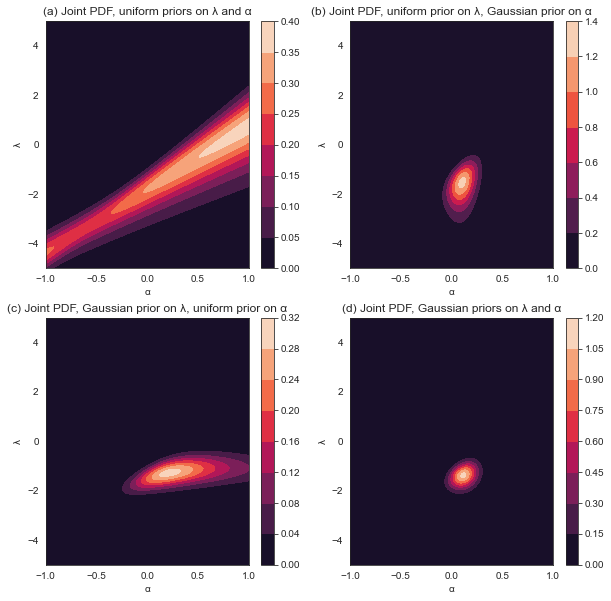

In [73]:
plt.figure(figsize=(10,10))
ax=plt.subplot(2,2,1)
plt.contourf(alphas,lams,JPDF_annan)
plt.colorbar()
plt.title("(a) Joint PDF, uniform priors on λ and α")
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,3)
plt.contourf(alphas,lams,JPDF_annan*justproc)
plt.title("(c) Joint PDF, Gaussian prior on λ, uniform prior on α")
plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,2)
plt.contourf(alphas,lams,justalpha*JPDF_annan)
plt.title("(b) Joint PDF, uniform prior on λ, Gaussian prior on α")
plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,4)
plt.contourf(alphas,lams,justalpha*JPDF_annan*justproc)
plt.title("(d) Joint PDF, Gaussian priors on λ and α")
plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

#plt.savefig("FIGS/Priors.png")

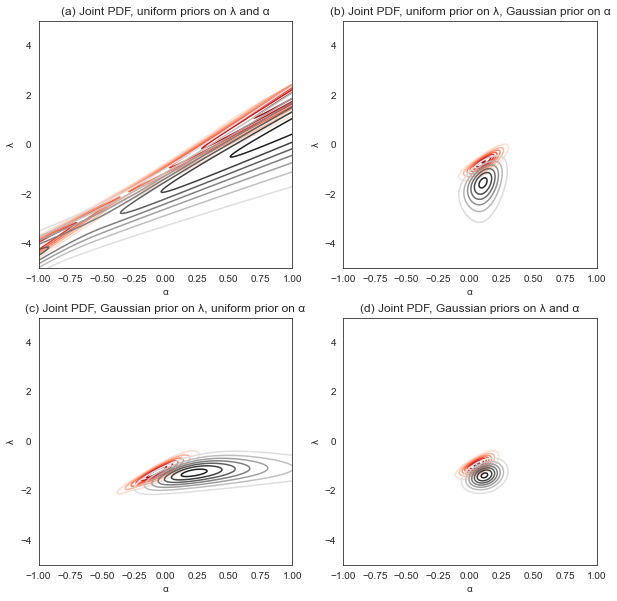

In [97]:
plt.figure(figsize=(10,10))
ax=plt.subplot(2,2,1)
plt.contour(alphas,lams,JPDF_tierney,cmap=cm.Reds)
plt.contour(alphas,lams,JPDF_annan,cmap=cm.gray_r)
#plt.colorbar()
plt.title("(a) Joint PDF, uniform priors on λ and α")
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,3)
plt.contour(alphas,lams,JPDF_tierney*justproc,cmap=cm.Reds)
plt.contour(alphas,lams,JPDF_annan*justproc,cmap=cm.gray_r)
plt.title("(c) Joint PDF, Gaussian prior on λ, uniform prior on α")
#plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,2)
plt.contour(alphas,lams,justalpha*JPDF_tierney,cmap=cm.Reds)
plt.contour(alphas,lams,justalpha*JPDF_annan,cmap=cm.gray_r)
plt.title("(b) Joint PDF, uniform prior on λ, Gaussian prior on α")
#plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,4)
plt.contour(alphas,lams,justalpha*JPDF_tierney*justproc,cmap=cm.Reds)
plt.contour(alphas,lams,justalpha*JPDF_annan*justproc,cmap=cm.gray_r)
plt.title("(d) Joint PDF, Gaussian priors on λ and α")
#plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

plt.savefig("FIGS/ParameterUncertainty.png")

(-2.5, 0.0)

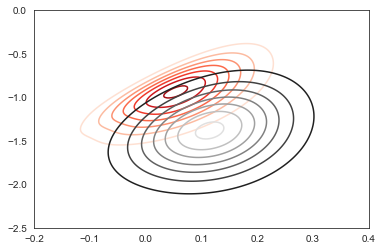

In [89]:
#plt.contour(alphas,lams,justalpha*JPDF_meta*justproc,cmap=cm.Purples)
plt.contour(alphas,lams,justalpha*JPDF_tierney*justproc,cmap=cm.Reds)
plt.contour(alphas,lams,justalpha*JPDF_annan*justproc,cmap=cm.gray)
plt.xlim(-0.2,0.4)
plt.ylim(-2.5,0)

In [76]:
with open("PICKLED/LGM_JPDF_meta_07132022.pkl","rb") as picklefile:
    JPDF_meta=pickle.load(picklefile)

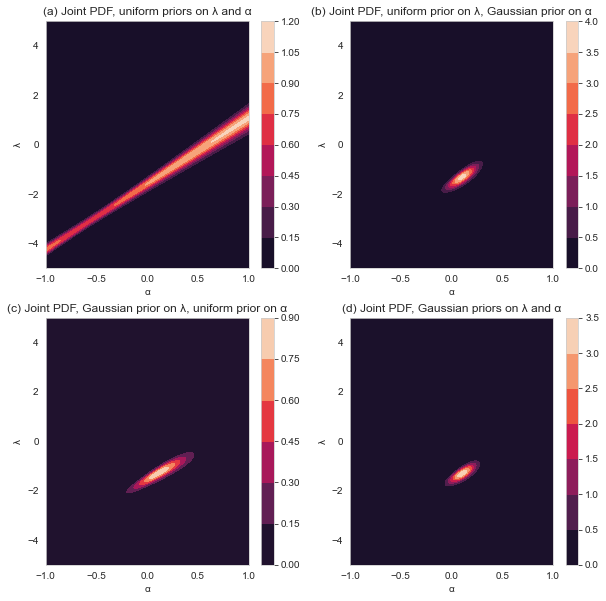

In [58]:
#META JPDF
plt.figure(figsize=(10,10))
ax=plt.subplot(2,2,1)
plt.contourf(alphas,lams,JPDF_meta)
plt.colorbar()
plt.title("(a) Joint PDF, uniform priors on λ and α")
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,3)
plt.contourf(alphas,lams,JPDF_meta*justproc)
plt.title("(c) Joint PDF, Gaussian prior on λ, uniform prior on α")
plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,2)
plt.contourf(alphas,lams,justalpha*JPDF_meta)
plt.title("(b) Joint PDF, uniform prior on λ, Gaussian prior on α")
plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

ax=plt.subplot(2,2,4)
plt.contourf(alphas,lams,justalpha*JPDF_meta*justproc)
plt.title("(d) Joint PDF, Gaussian priors on λ and α")
plt.colorbar()
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

In [98]:
alpha_gaussian=normlam(np.sum(justalpha*JPDF_annan,axis=1))
S_alpha_gaussian=lam_to_S(alpha_gaussian)
alpha_0=normlam(LGM0)
S_alpha_0=lam_to_S(alpha_0)

In [99]:
alpha_gaussian_tierney=normlam(np.sum(justalpha*JPDF_tierney,axis=1))
S_alpha_gaussian_tierney=lam_to_S(alpha_gaussian_tierney)
LGM0_tierney=np.array([LGM_likelihood(x,0,tempfrom="tierney") for x in lams])
alpha_0_tierney=normlam(LGM0_tierney)
S_alpha_0_tierney=lam_to_S(alpha_0_tierney)

In [100]:
alpha_uniform = normlam(np.sum(JPDF_annan,axis=1))
S_alpha_uniform=lam_to_S(alpha_uniform)

In [101]:
print(Ses[np.argmax(S_alpha_0_tierney)])
print(Ses[np.argmax(S_alpha_gaussian)])

3.4343434343434343
1.9191919191919191


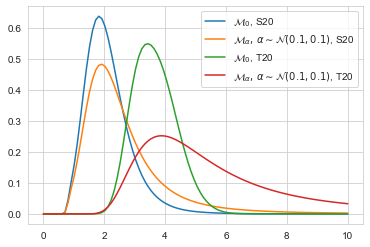

In [63]:
plt.plot(Ses,normlam(S_alpha_0,x=Ses),label=r"$\mathcal{M}_0$, S20")
plt.plot(Ses,normlam(S_alpha_gaussian,x=Ses),label=r"$\mathcal{M}_{\alpha},\, \alpha \sim \mathcal{N}(0.1,0.1)$, S20")

plt.plot(Ses,normlam(S_alpha_0_tierney,x=Ses),label=r"$\mathcal{M}_0$, T20")
plt.plot(Ses,normlam(S_alpha_gaussian_tierney,x=Ses),label=r"$\mathcal{M}_{\alpha},\, \alpha \sim \mathcal{N}(0.1,0.1)$, T20")
#plt.plot(Ses,S_alpha_uniform)
plt.legend()
#plt.savefig("FIGS/LGM_estimates.png")

In S20, we used a Gaussian prior for the state dependence.  This gives a different pdf than the marginal pdf we get by integrating over $\lambda$.

Text(0.5, 0, 'α')

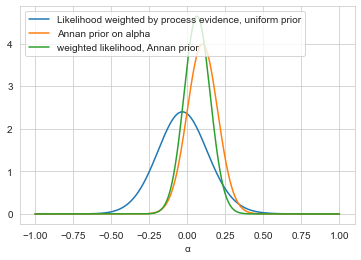

In [64]:
plt.figure()
plt.plot(alphas,np.dot(proc,JPDF_tierney)/np.trapz(np.dot(proc,JPDF_tierney),x=alphas),label="Likelihood weighted by process evidence, uniform prior")
plt.plot(alphas,alphaprior,label="Annan prior on alpha")
plt.plot(alphas,np.dot(proc,JPDF_tierney)*alphaprior/np.trapz(np.dot(proc,JPDF_tierney)*alphaprior,x=alphas),label="weighted likelihood, Annan prior")
plt.legend(ncol=1,loc=2)
plt.xlabel("α")

If you literally have no physical idea what the state dependence might be, net positive feebacks and strong state dependence best fit the data.  This is unphysical.

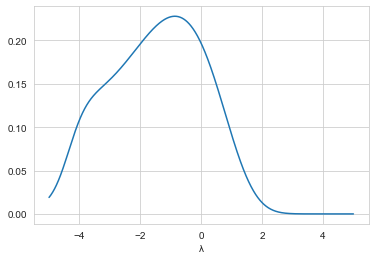

In [65]:
plt.figure()
JPDF_uniformalphanoproc=np.sum(JPDF_annan,axis=1)/np.trapz(np.sum(JPDF_annan,axis=1),x=lams)

plt.plot(lams,JPDF_uniformalphanoproc)
tmp=plt.xlabel("λ")

This expresses the (very obvious) fact that if you want the LGM to teach you anything, you need to have some sort of constraint on the state dependence $\alpha$.  If your prior treats every value of $\alpha$ as equally likely, the constraint from the LGM will be identical to that from the process evidence.  If, however, you know something (or believe you know something) about what, physically, the state dependence might be, then this allows the LGM evidence to place new additional constraints on the feedbacks.

Incorporating uncertainty in the state dependence broadens the range of possible $\lambda$ obtained from the LGM

# History
## Observations
Using Bellouin aerosol forcing as calculated by Piers and Mark for (Sherwood et al, 2020).

In [102]:
def bellouin_ringberg_stats_fix_200311_ERFaer(nsamples):
#From WCRP code downloaded 3/10
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import math

    # Distribution type
    # u - uniform, but arguments are 16th and 84th percentile
    #       assumes uniform outside these values (no very large values)
    # v - uniform, next two arguments are upper and lower bounds
    # c - constant value
    # n - normal distribution with bounds as 2 sigma width around an average mean

    d = {}
    d['rsdt'] =          ['c', -340]

    # Aerosol variables
    d['dtau'] =          ['u', 0.02,   0.04]
    d['tau'] =           ['u', 0.13,   0.17]

    # RFari terms
    d['S_tau'] =         ['u', -20,   -27]
    d['RFari_cloudy'] =  ['u', -0.1, 0.1 ]

    # RAari
    d['dR_dRatm'] =      ['u', -0.1, -0.3]
    d['dRatm_dtau'] =    ['u', 17,     35]

    # Cloud fractions
    d['c_tau'] =         ['u', 0.59,  0.71]
    d['c_N'] =           ['u', 0.19,  0.29]
    d['c_L'] =           ['u', 0.21, 0.29 ]
    d['c_C'] =           ['u', 0.59, 1.07 ]         

    # Nd sensitivity to aerosol, and adjustment terms
    d['beta_N_tau'] =   ['u', 0.3,    0.8]
    d['beta_L_N'] =     ['u', -0.36,  -0.011] 
    d['beta_C_N'] =       ['u', 0,      0.1]

    # Cloud albedo terms
    d['S_N'] =           ['u', -26,    -27]
    d['S_L'] =           ['u', -54,    -56]
    d['S_C'] =           ['u', -91,   -153]


    ############################################
    # Create the distributions and store in ds #
    ############################################

    ds = {}
    for name in d.keys():
      if d[name][0] == 'c':
          ds[name] = d[name][1]
      elif d[name][0] == 'u':
          diff = 16*(d[name][2]-d[name][1])/(84-16)
          ds[name] = np.random.uniform(d[name][1]-diff, d[name][2]+diff, nsamples)
      elif d[name][0] == 'v':
          ds[name] = np.random.uniform(d[name][1], d[name][2], nsamples)
      elif d[name][0] == 'n':
          cent = (d[name][2]+d[name][1])/2
          spread = (d[name][2]-d[name][1])/2
          ds[name] = np.random.uniform(cent, spread, nsamples)

    ############################
    # The Ringberg Equation!!! #
    ############################
    rfari = ds['dtau']*ds['S_tau']*(1-ds['c_tau'])+ds['RFari_cloudy']
    rfari_adj = ds['dtau']*ds['dR_dRatm']*ds['dRatm_dtau']

    ds['dlntau'] = ds['dtau']/ds['tau']
    deltan = ds['dlntau']*ds['beta_N_tau']

    rfaci = ds['dlntau']*ds['beta_N_tau']*ds['S_N']*ds['c_N']
    erfaci_L = ds['dlntau']*ds['beta_N_tau']*ds['beta_L_N']*ds['S_L']*ds['c_L']
    erfaci_C = ds['dlntau']*ds['beta_N_tau']*ds['beta_C_N']*ds['S_C']*ds['c_C']

    ERFaer=rfari+rfari_adj+rfaci+erfaci_L+erfaci_C
    return ERFaer

def read_hist_forc(hist_forcing_version='Bellouin_2020_eqn_8',\
                   alternative_pi_period=False,
                  period_1850_2005_2015=False,\
                  period_1750_2018=False):
    inpath = "WCRP_ECS_assessment_code_200714/"
    #start by making the forcing according to Piers' code and commentary

    #note the only edit I made to his files is to make the col names automatically readable for the 2nd one (ie removing spaces)

    # Piers Forster's code retained in comments marked PF 
    # James Annan's code retained in comments marked JDA



    # Read in data

    from io import StringIO   # StringIO behaves like a file object
    #from google.colab import drive
    #drive.mount('/content/gdrive')

    # **** Read in historical forcing upper, mid and lower ranges ****

    if hist_forcing_version == 'Bellouin_2020_eqn_8':
        hist_forcing_ranges='WCRP_forcing_ranges_200311.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_Bellouinaerosol2.csv'

    if hist_forcing_version == 'Bellouin_2020_constrained':
        hist_forcing_ranges='WCRP_forcing_ranges_Bellouinaerosol_constrained_200321.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_Bellouinaerosol2.csv'

    if hist_forcing_version == 'AR5_extended':
        hist_forcing_ranges='IPCCAR5_forcing_ranges_200320.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_AR5aerosol_200320.csv'

    best_upper_lower = pd.read_csv(inpath+hist_forcing_ranges,nrows=3)

    best=best_upper_lower.iloc[0]
    lower=best_upper_lower.iloc[1]
    upper=best_upper_lower.iloc[2]

    # PF ; assumes 90% are 1.65 sigma
    # PF sdlower=(best-lower)/1.65
    # PF sdupper=(upper-best)/1.65

    # MJW calulate standard deviations which would give lower and upper values as 5-95% ranges
    # assumes 90% are 1.64 sigma
    sdlower=(best-lower)/1.64
    sdupper=(upper-best)/1.64

    

    # **** Read in AR5 annual mean forcing data ****

    df=pd.read_csv(inpath+hist_monthly_forcings,delimiter=',',skiprows=19)

    #print (forc_table["Year/month"]
    df = df.set_index(['Year/month']) 

    df_baseline=df.loc[1861:1880]
    #df_recent=df.loc[2002:2017]
    df_recent=df.loc[2006:2018] # updated 16/3/20

    if alternative_pi_period:
        df_baseline=df.loc[1850:1900]

    if period_1850_2005_2015:
        df_baseline=df.loc[[1850,1850]]
        df_recent=df.loc[2005:2015]

    if period_1750_2018:
        df_baseline=df.loc[[1750,1750]]
        df_recent=df.loc[[2018,2018]]

   # print (df_baseline)
   # print (df_recent)

    # JDA: CO2 forcing is based on F2x so I will back-calculate the doubling fraction from this
    #
    # JDA: now generate a sample of all the other forcings

    uncs_neg = ( best - lower ) / (1.64 * best )
    uncs_pos = ( upper - best ) / (1.64 * best )

    return (df_recent,df_baseline,uncs_neg,uncs_pos)

def get_total_forcing(nsamp):
    #Aerosol forcing is different- median is -1.1, not -1.179
    df_recent,df_baseline,uncs_neg,uncs_pos=read_hist_forc()

   
    labels = ['Other WMGHG','O3 (T)','O3(S)','ERF LUC','Vapour','BC snow','contrails','Solar','Volcanic',"total aerosol ERF"] 
    f_other = np.zeros(nsamp)
    devs = np.random.normal(loc=0.0, scale=1.0, size=nsamp)
    for label in labels:
        baseline=df_baseline[label].to_numpy()
        baseline=np.mean(baseline)

        recent=df_recent[label].to_numpy()
        recent=np.mean(recent)

        if label != "total aerosol ERF":

            devscaled = (devs >= 0) * devs * uncs_pos[label] 
            devscaled = devscaled + (devs < 0) * devs * uncs_neg[label]
            f_component = (recent - baseline) * (1+devscaled)
            f_other=f_other+f_component
        else:
            #aerosols
            ERFaer = bellouin_ringberg_stats_fix_200311_ERFaer(nsamp)
            #devscaled=ERFaer/np.median(ERFaer)-1.0
            # rescale by the factor that reproduces Bellouin et al 2020 PDF between 1850 and 2005-2015
            peak_ERFaer=-0.87
            devscaled=ERFaer/peak_ERFaer-1.0
            #print(recent-baseline)
            total_aerosol_forcing=(recent - baseline) * (1+devscaled)
            #print("Aerosol 5-95 range",np.percentile(total_aerosol_forcing,5),np.percentile(total_aerosol_forcing,95))
            #print("aserosol median",np.median(total_aerosol_forcing))


    #CO2
    label='CO2'
    baseline=df_baseline[label].to_numpy()
    baseline=np.mean(baseline)

    recent=df_recent[label].to_numpy()
    recent=np.mean(recent)

    CO2_hist_mean = (recent - baseline)

    F2x=4.
    F2x_error=np.random.normal(F2x,0.49/1.64,size=nsamp)
    CO2_hist=CO2_hist_mean*F2x/np.mean(F2x)

    tot_f=f_other+total_aerosol_forcing+CO2_hist
    return tot_f


In [104]:
Fwebb=pd.read_csv("f_bin_centres.csv",header=None)
bincentres=Fwebb[0].values
likwebbF=pd.read_csv("total_hist_erf_prior.csv",header=None)
forcing_prior_webb=likwebbF[0].values

In [105]:
from scipy.interpolate import interp1d
webbinterp = interp1d(bincentres, forcing_prior_webb, kind='cubic',fill_value=0,bounds_error=False)



Text(0.5, 0, 'ΔF')

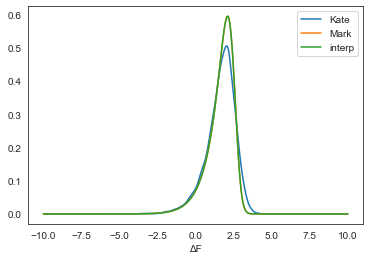

In [106]:
plt.figure()
dF_obs=get_total_forcing(10000)
#tmp=plt.hist(dF_obs,100,density=True)
x=np.linspace(-10,10,1000)
forcing_prob=stats.gaussian_kde(dF_obs)
plt.plot(x,forcing_prob(x),label="Kate")
plt.plot(bincentres,forcing_prior_webb,label="Mark")
plt.plot(x,webbinterp(x),label="interp")
#plt.xlim(-2,4)
#plt.ylim(0,2)
plt.legend()
plt.xlabel("ΔF")


## Other observations


Temperature and imbalance estimates taken from Table 5 of (Sherwood et al 2020); 5-95% confidence levels converted into $\sigma$ using normal distribution

$\Delta T \sim \mathcal{N}(1.03,0.085)$

$\Delta N \sim \mathcal{N}(0.6,0.18)$

In [107]:
nsamp=1000
scale90=stats.norm.interval(.9)[1]

dF_obs=get_total_forcing(nsamp)
dT_obs=np.random.normal(1.03,(.17-.03)/scale90,nsamp)
dN_obs=np.random.normal(.6,0.3/scale90,nsamp)

x=dN_obs-dT_obs

F2x=4.
F2x_error=np.random.normal(F2x,0.49/1.64,size=nsamp)
    

Calculate a kernel density estimate from these samples (do this numerically since we don't have a functional form for $\Delta F$)

In [108]:
test_values=np.zeros((3,nsamp))
test_values[0]=dT_obs
test_values[1]=dF_obs
test_values[2]=dN_obs


test_kde=stats.gaussian_kde(test_values)

The simplest energy balance model is 

$\Delta N = \lambda \Delta T + \Delta F$

This is deterministic: if we knew the "true" values of the imbalance, temperature change, and forcing, we'd know the feedback parameter exactly.  That is: there is no randomness in $\lambda$ or uncertainty in this model: the uncertainty in $\lambda$ is completely due to the uncertainty in the observations. 

(Aside: if we consider shorter-term observations, we have to consider internal variability.  In that case, the model is $$\Delta N = \lambda \Delta T + \Delta F+V$$ and we have to consider a further hierarchical step 
$$\lambda_{obs} \sim \mathcal{N}(\lambda_{true},\sigma_V^2)$$ where we assume the observed values of $\lambda$ are normally distributed about the "true" (latent) feedback parameter and $\sigma_V^2$ represents the scatter due to internal variability of the climate system.  But let's not get ahead of ourselves.)

This model defines a plane in $(\Delta T, \Delta N, \Delta F)$ space.

Intuitively, the likelihood of the observed evidence given a value of $\lambda$ depends on the intersection of the plane defined by $\lambda$ and the joint PDF of the observations.  A plane that cuts through a large section of the PDF corresponds to a high likelihood of the evidence given that particular $\lambda$, while a plane that just grazes the side corresponds to a low likelihood.  This is a 3D generalization of the method used in Sherwood et al for the historical section.

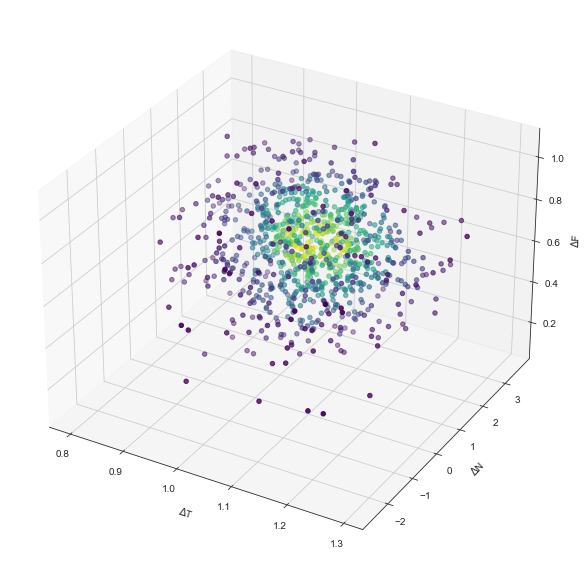

In [109]:


def plot_plane_lam(lam,ax):
    Ts = np.linspace(.8,1.3,int(nsamp/100))
    Fs = np.linspace(-2,4.0,int(nsamp/100))
    xx,yy=np.meshgrid(Ts,Fs)
    #zz = -1/lam*(xx-yy)
    zz = lam*xx+yy
    ax.plot_surface(xx,yy,zz,alpha=.3,label="lam = "+str(lam))

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,20))
plt.set_cmap(cm.viridis)
ax.scatter(test_values[0], test_values[1], test_values[2], c=test_kde(test_values))
tmp=ax.set_xlabel(r'$\Delta$T')
tmp=ax.set_ylabel(r'$\Delta$N')
tmp=ax.set_zlabel(r'$\Delta$F')

# plot_plane_lam(0,ax=ax)
# plot_plane_lam(-1.41,ax=ax)

# plot_plane_lam(-.5,ax=ax)
# ax.set_zlim(-1,3)
# plt.show()

Define the likelihood as the surface integral of the joint PDF of observations over the plane defined by $\lambda$:

$$\int \int PDF(\Delta T, \Delta F, \Delta N) dS = \int \int PDF( \vec{r}(u,v) )|| r_u \times r_v|| dA$$
where 
$$\vec{r} =u \hat{i} + v \hat{j} + (\lambda u+ v)\hat{k}$$
If the observations $\Delta T, \Delta F, \Delta N$ are all independent and normally distributed, we can write this integral in terms of Gaussians and get a nice analytic functional form.  This is moot because $\Delta F$ is not normally distributed.  So let's do it numerically:

In [110]:
#Functional form of the likelihood P(evidence | λ)
#This takes longer than I'd like, but maybe we can fit a spline to a bunch of samples to make it go faster
def likelihood_density_lambda(λ,Δλ,tmin=-10,tmax=10,qmin=-10,qmax=10):
    ru=np.array([1,0,λ-Δλ])
    rv=np.array([0,1,1])
    jacobian=np.linalg.norm(np.cross(ru,rv))
    func=lambda u,v: test_kde((u,v,(λ-Δλ)*u+v))*jacobian
    return integrate.dblquad(func,tmin,tmax,lambda u: qmin, lambda u: qmax)[0]

In [111]:
dF_obs=get_total_forcing(nsamp)

forcing_prob=stats.gaussian_kde(dF_obs)
def PT_hist(T,tempfrom="tierney"):
      
    muT= 1.03
    sigT=(.17-.03)/scale90

     
    return np.exp(-0.5*(T-muT)**2/sigT**2)*1/(np.sqrt(2*np.pi)*sigT)
def PN_hist(N):
    
    muN=0.6
    sigN=0.3/scale90

   
    return np.exp(-0.5*(N-muN)**2/sigN**2)*1/(np.sqrt(2*np.pi)*sigN)

def PF_hist(F):
    return forcing_prob(F)


def quicker_kde(T,F,N):
    return PT_hist(T)*PF_hist(F)*PN_hist(N)
def quickest_kde(T,F,N):
    return PT_hist(T)*webbinterp(F)*PN_hist(N)


def likelihood_density_lambda_quick(λ,Δλ,tmin=-10,tmax=10,qmin=-10,qmax=10):
    ru=np.array([1,0,λ-Δλ])
    rv=np.array([0,1,1])
    jacobian=np.linalg.norm(np.cross(ru,rv))
    func=lambda u,v: quicker_kde(u,v,(λ-Δλ)*u+v)*jacobian
    return integrate.dblquad(func,tmin,tmax,lambda u: qmin, lambda u: qmax)[0]


def likelihood_density_lambda_quickest(λ,Δλ,tmin=-10,tmax=10,qmin=-10,qmax=10):
    ru=np.array([1,0,λ-Δλ])
    rv=np.array([0,1,1])
    jacobian=np.linalg.norm(np.cross(ru,rv))
    func=lambda u,v: quickest_kde(u,v,(λ-Δλ)*u+v)*jacobian
    return integrate.dblquad(func,tmin,tmax,lambda u: qmin, lambda u: qmax)[0]

In [112]:

pickle_historical=False
if pickle_historical:
    today=datetime.date.today().strftime("%m%d%Y")
    lam_hist=[]
    #lams=np.linspace(-5,5,1000)
    #pattern = np.linspace(-2,2,500)
    for i in range(len(lams)):
        print(i)
        lam=lams[i]
      
        lam_hist+=[likelihood_density_lambda_quickest(lam,0,tmin=-np.inf,tmax=np.inf,qmin=-np.inf,qmax=np.inf)]
    import pickle
    with open("PICKLED/lam_hist_"+today+".dat","wb") as picklefile:
        pickle.dump(np.array(lam_hist),picklefile)
else:
    with open("PICKLED/lam_hist_06142022.dat","rb") as picklefile:
        lam_hist=pickle.load(picklefile)


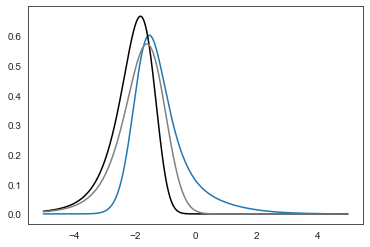

In [123]:
plt.figure()
plt.plot(lams,normlam(lam_hist),label="Historical likelihood")
plt.plot(lams,normlam(LGM_alpha_annan[2]),c="k",label="")
plt.plot(lams,alpha_gaussian,c=cm.gray(.5))

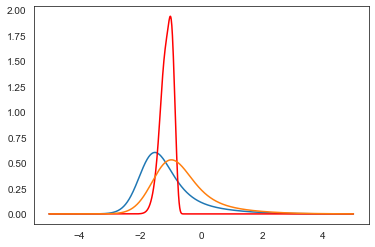

In [132]:
plt.figure()
plt.plot(lams,normlam(lam_hist))
plt.plot(lams,normlam(LGM_alpha_tierney[2]),c="r")
plt.plot(lams,historical_patterneffect_gaussian_prior)

Text(0.5, 0, 'λ')

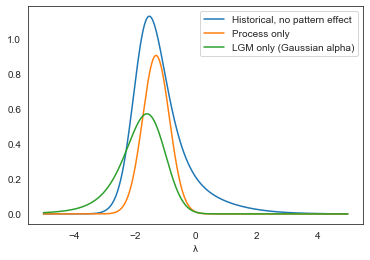

In [124]:
plt.figure()
plt.plot(lams,lam_hist,label="Historical, no pattern effect")
plt.plot(lams,proc,label="Process only")
plt.plot(lams,alpha_gaussian,label="LGM only (Gaussian alpha)")
plt.legend()
plt.xlabel("λ")

In [125]:
lams[np.argmax(lam_hist)]

-1.5265265265265264

In [126]:
#retrofit with pattern effect
pattern = np.linspace(-2,2,500)
patternshape=len(pattern)
histJPDF=np.zeros((lamshape,patternshape))
for i in range(lamshape):
    for j in range(patternshape):
        lamtest=lams[i]
        patttest=pattern[j]
        tot_lam=lamtest-patttest
        if np.abs(tot_lam)>=5.:
            lik=0.
        else:
            lik=lam_hist[np.argmin(np.abs(lams-tot_lam))  ]
        histJPDF[i,j]=lik

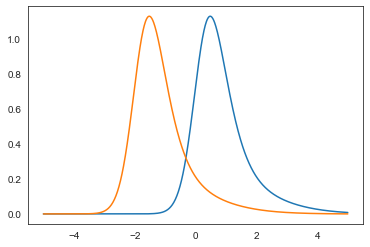

In [127]:
plt.figure()
plt.plot(lams,histJPDF[:,-1])
plt.plot(lams,lam_hist)

Text(0.5, 0, 'Δλ')

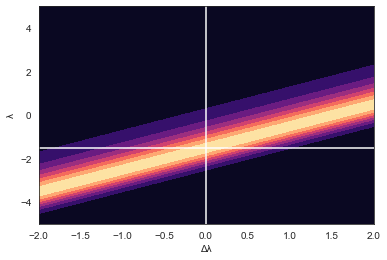

In [128]:
plt.figure()
plt.set_cmap(cm.magma)
plt.contourf(pattern,lams,histJPDF)
plt.contourf(pattern,lams,histJPDF)
plt.axvline(0,c="w")
plt.axhline(lams[np.argmax(lam_hist)],c="w")
plt.ylabel("λ")
plt.xlabel("Δλ")

## Prior on $\Delta \lambda$
Assume, as in S20, a Gaussian prior on the pattern effect

In [129]:
patternmean=0.5
patternsigma=0.5/scale90

patternprior=np.exp(-1/2.*(pattern-patternmean)**2/patternsigma**2)*1/(np.sqrt(2*np.pi)*patternsigma)



patternprior2=np.exp(-1/2.*(pattern-0.2)**2/patternsigma**2)*1/(np.sqrt(2*np.pi)*patternsigma)

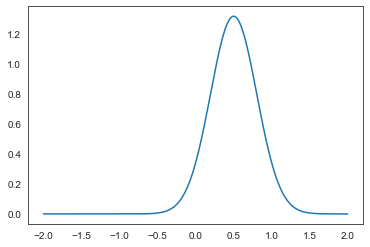

In [130]:
plt.figure()
plt.plot(pattern,patternprior)

The effect of this prior is to shift the PDF for $\lambda$ (marginalized over $\Delta \lambda$ ) to less negative feedbacks -> higher climate sensitivities

Text(0, 0.5, 'Likelihood')

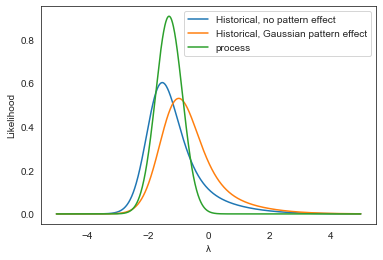

In [131]:
plt.figure()

plt.plot(lams,lam_hist/np.trapz(lam_hist,x=lams),label="Historical, no pattern effect")
historical_patterneffect_gaussian_prior=np.dot(histJPDF,patternprior)/np.trapz(np.dot(histJPDF,patternprior),x=lams)
historical_2_patterneffect_gaussian_prior=np.dot(histJPDF,patternprior2)/np.trapz(np.dot(histJPDF,patternprior2),x=lams)
plt.plot(lams,historical_patterneffect_gaussian_prior,label="Historical, Gaussian pattern effect")
plt.plot(lams,proc, label="process")
plt.legend()
plt.xlabel("λ")
plt.ylabel("Likelihood")

In [86]:
nsamps_big=F2x_error.shape[0]
#lams_hpt=np.random.choice(lams,nsamps_big,p=histpriortest/np.sum(histpriortest))

S_hist_nopatt=lam_to_S(lam_hist)
S_hist_patt=lam_to_S(historical_patterneffect_gaussian_prior)

In [87]:
Ses[np.argmax(S_hist_nopatt)]

2.2222222222222223

Text(0.5, 0, 'S')

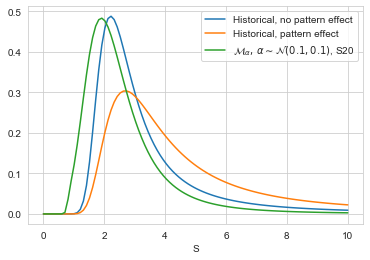

In [88]:
plt.figure()
plt.plot(Ses,normlam(S_hist_nopatt,x=Ses),label="Historical, no pattern effect")
plt.plot(Ses,normlam(S_hist_patt,x=Ses),label="Historical, pattern effect")
plt.plot(Ses,normlam(S_alpha_gaussian,x=Ses),label=r"$\mathcal{M}_{\alpha},\, \alpha \sim \mathcal{N}(0.1,0.1)$, S20")
plt.legend()
plt.xlabel("S")

In [89]:
def ana_historical(λ,Δλ):
    μ_x = 1.03
    σ_x = 0.2/scale90

    μ_y = 2.2
    σ_y = 0.71/scale90

    μ_z = 0.59
    σ_z = 0.35/scale90
    
    A11=1/σ_x**2 + (λ-Δλ)**2/σ_z**2
    A12 = (λ-Δλ)/σ_z**2
    A21 = (λ-Δλ)/σ_z**2
    A22 = 1/σ_y**2 + 1/σ_z**2
    A=np.array([[A11,A12],[A21,A22]])
    J1 = μ_x/σ_x**2 + (λ-Δλ)*μ_z/σ_z**2
    J2 =  μ_y/σ_y**2 + μ_z/σ_z**2
    J=np.array([J1,J2])

    C=μ_x**2/σ_x**2+μ_y**2/σ_y**2+μ_z**2/σ_z**2

    L=np.sqrt((λ-Δλ)**2+2)*2*np.pi/np.sqrt(np.linalg.det(A))*np.exp(-0.5*C)*np.exp(0.5*np.dot(np.dot(np.transpose(J),np.linalg.inv(A)),J))
    return L



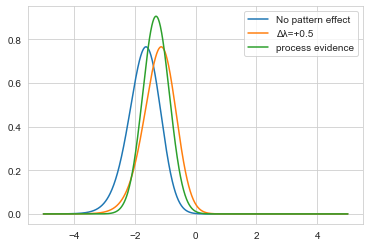

In [90]:
tst0=np.array([ana_historical(lam,0) for lam in lams])
tst05=np.array([ana_historical(lam,0.5) for lam in lams])
plt.figure()
plt.plot(lams,normlam(tst0),label="No pattern effect")
plt.plot(lams,normlam(tst05),label="Δλ=+0.5")
plt.plot(lams,proc,label="process evidence")
plt.legend()

In [91]:
pattern = np.linspace(-2,2,500)
patternshape=len(pattern)
histJPDF_ana=np.zeros((lamshape,patternshape))
for i in range(lamshape):
    for j in range(patternshape):
        lamtest=lams[i]
        patttest=pattern[j]
       
        histJPDF_ana[i,j]=ana_historical(lamtest,patttest)

In [92]:
#constraining the pattern effect based on LGM

# Posterior predictive distribution
$$P(Y_{pred} | Y) = \int_{\Theta} P(Y_{pred} | \Theta) p(\Theta | Y) d\Theta$$
For the historical, $Y_{pred} = (\Delta T, \Delta F, \Delta N)$
The first term in the integral is the likelihood of observing $Y_{pred}$ given the posterior $\Theta$

Using the LGM evidence from S20, we find greater overlap in the posteriors for lambda when using the Gaussian prior on alpha: a positive state dependence makes the results agree more with the historical evidence.

Marginalizing over alpha : assessing models against LGM evidence only

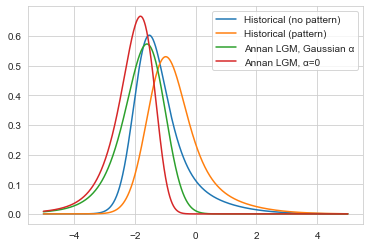

In [93]:
plt.figure()
plt.plot(lams,normlam(lam_hist),label="Historical (no pattern)")
plt.plot(lams,normlam(historical_patterneffect_gaussian_prior),label="Historical (pattern)")
plt.plot(lams,alpha_gaussian, label="Annan LGM, Gaussian α")
plt.plot(lams,alpha_0,label="Annan LGM, α=0")
plt.legend()
#plt.plot(lams,alpha_gaussian)

In [94]:
print("M0 Annan historical", np.trapz(lam_hist*alpha_0,x=lams))
print("M0 Tierney historical", np.trapz(lam_hist*alpha_0_tierney,x=lams))

M0 Annan historical 0.6270567133686501
M0 Tierney historical 0.8928324760531559


In [95]:
print("Mα Annan", np.trapz(lam_hist*alpha_gaussian,x=lams))
print("Mα Tierney", np.trapz(lam_hist*alpha_gaussian_tierney,x=lams))

Mα Annan 0.6785210685501867
Mα Tierney 0.6164853841680041


In [96]:
print("M0 Annan process", np.trapz(proc*alpha_0,x=lams))
print("M0 Tierney process", np.trapz(proc*alpha_0_tierney,x=lams))

M0 Annan process 0.3565187707588955
M0 Tierney process 0.7690221406169823


In [97]:
print("Mα Annan process", np.trapz(proc*alpha_gaussian,x=lams))
print("Mα Tierney process", np.trapz(proc*alpha_gaussian_tierney,x=lams))

Mα Annan process 0.42948463448015095
Mα Tierney process 0.44329498970679915


In [98]:
print("M0 historical process", np.trapz(proc*normlam(lam_hist),x=lams))
print("Mpatt historical process", np.trapz(proc*historical_patterneffect_gaussian_prior,x=lams))

M0 historical process 0.46822599955346855
Mpatt historical process 0.39791033557412814


In [99]:
print("M00 Annan ", np.trapz(normlam(lam_hist)*alpha_0,x=lams))
print("Mα0 Annan ", np.trapz(normlam(lam_hist)*alpha_gaussian,x=lams))
print("M0Δλ Annan ", np.trapz(historical_patterneffect_gaussian_prior*alpha_0,x=lams))
print("MαΔλ Annan ", np.trapz(historical_patterneffect_gaussian_prior*alpha_gaussian,x=lams))

M00 Annan  0.3339335744995389
Mα0 Annan  0.3613404672393681
M0Δλ Annan  0.1835405383727073
MαΔλ Annan  0.253690904457585


In [100]:
print("M00 Tierney ", np.trapz(normlam(lam_hist)*alpha_0_tierney,x=lams))
print("Mα0 Tierney ", np.trapz(normlam(lam_hist)*alpha_gaussian_tierney,x=lams))
print("M0Δλ Tierney ", np.trapz(historical_patterneffect_gaussian_prior*alpha_0_tierney,x=lams))
print("MαΔλ Tierney ", np.trapz(historical_patterneffect_gaussian_prior*alpha_gaussian_tierney,x=lams))

M00 Tierney  0.47547013499945134
Mα0 Tierney  0.32830390548887056
M0Δλ Tierney  0.49260386428234143
MαΔλ Tierney  0.44803460720456323


In [101]:
print("MαΔλ_2 Tierney ", np.trapz(historical_patterneffect_gaussian_prior*alpha_gaussian_tierney,x=lams))

MαΔλ_2 Tierney  0.44803460720456323


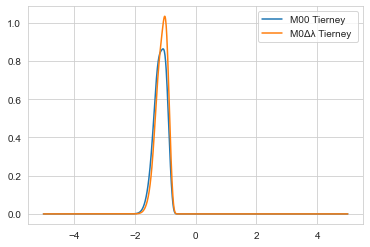

In [102]:
plt.figure()
plt.plot(lams,normlam(lam_hist)*alpha_0_tierney,label="M00 Tierney ")
plt.plot(lams,historical_patterneffect_gaussian_prior*alpha_0_tierney,label="M0Δλ Tierney ")
plt.legend()

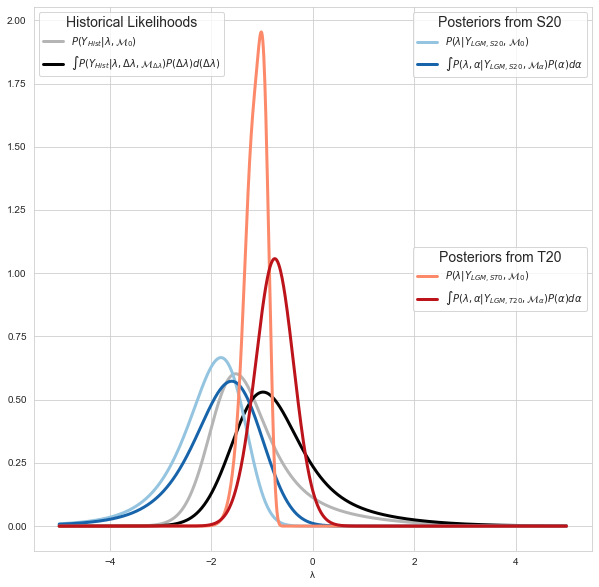

In [103]:
plt.figure(figsize=(10,10))
lw=3
plt.plot(lams,normlam(lam_hist),\
         label=r"Historical likelihood: $P(Y_{Hist}| \Theta, \mathcal{M}_{0})$",\
         c=cm.Greys(.4),lw=lw)
plt.plot(lams,historical_patterneffect_gaussian_prior,\
         label=r"$P(Y_{Hist}| \Theta, \mathcal{M}_{\Delta \lambda})$",\
         c=cm.Greys(.99),lw=lw)

plt.plot(lams,normlam(alpha_0),\
         label=r"$P(\lambda  | Y_{LGM, S20},\mathcal{M}_{0})$",\
         c=cm.Blues(.4),lw=lw)
plt.plot(lams,normlam(alpha_gaussian),\
         label=r"$\int P(\lambda ,\alpha | Y_{LGM, S20},\mathcal{M}_{\alpha}) P(\alpha) d\alpha$",\
         c=cm.Blues(.8),lw=lw)

plt.plot(lams,normlam(alpha_0_tierney),\
         label=r"$P(\lambda  | Y_{LGM, T20},\mathcal{M}_{0})$",\
         c=cm.Reds(.4),lw=lw)
plt.plot(lams,normlam(alpha_gaussian_tierney),\
         label=r"$\int P(\lambda ,\alpha | Y_{LGM, T20},\mathcal{M}_{\alpha}) P(\alpha) d\alpha$",\
         c=cm.Reds(.8),lw=lw)


lines=plt.gca().get_lines()

leg1=plt.legend([lines[i] for i in [0,1]],\
           [r"$P(Y_{Hist}| \lambda, \mathcal{M}_{0})$", \
            r"$\int P(Y_{Hist}| \lambda, \Delta \lambda , \mathcal{M}_{\Delta \lambda}) P(\Delta \lambda) d(\Delta\lambda)$"],\
           loc='upper left',title="Historical Likelihoods",title_fontsize=14)
leg2=plt.legend([lines[i] for i in [2,3]],\
           [r"$P(\lambda  | Y_{LGM, S20},\mathcal{M}_{0})$",\
            r"$\int P(\lambda ,\alpha | Y_{LGM, S20},\mathcal{M}_{\alpha}) P(\alpha) d\alpha$"],\
           loc='upper right',title="Posteriors from S20",title_fontsize=14)

leg3=plt.legend([lines[i] for i in [4,5]],\
           [r"$P(\lambda  | Y_{LGM, ST0},\mathcal{M}_{0})$",\
            r"$\int P(\lambda ,\alpha | Y_{LGM, T20},\mathcal{M}_{\alpha}) P(\alpha) d\alpha$"],\
           loc='center right',title="Posteriors from T20",title_fontsize=14)
plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)
plt.xlabel("λ")

plt.savefig("FIGS/PPDs.png")

# Two towers problem

Text(0.5, 1.0, '(b): Resolved')

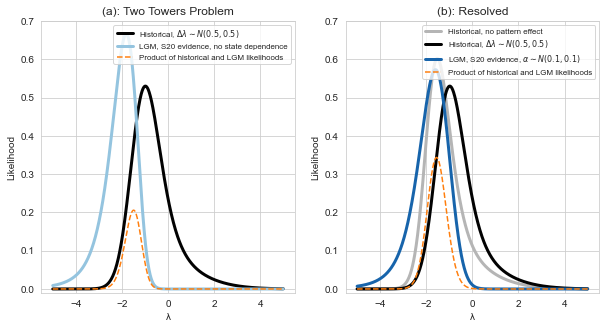

In [104]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
# plt.plot(lams,normlam(lam_hist),\
#          label=r"Historical, no pattern effect",\
#          c=cm.Greys(.4),lw=lw)
plt.plot(lams,historical_patterneffect_gaussian_prior,\
         label=r"Historical, $\Delta \lambda \sim N(0.5,0.5)$",\
         c=cm.Greys(.99),lw=lw)

plt.plot(lams,normlam(alpha_0),\
         label="LGM, S20 evidence, no state dependence",\
         c=cm.Blues(.4),lw=lw)

plt.plot(lams,normlam(alpha_0)*historical_patterneffect_gaussian_prior,"--",c=cm.tab10(1),label="Product of historical and LGM likelihoods")
# plt.plot(lams,normlam(alpha_gaussian),\
#          label=r"LGM, S20 evidence, $\alpha \sim N(0.1,0.1)$",\
#          c=cm.Blues(.8),lw=lw)
plt.legend(loc="upper right",fontsize=8)
plt.xlabel("λ")
plt.ylim(-0.01,0.7)
plt.ylabel("Likelihood")
plt.title("(a): Two Towers Problem")
plt.subplot(1,2,2)

plt.plot(lams,normlam(lam_hist),\
         label=r"Historical, no pattern effect",\
         c=cm.Greys(.4),lw=lw)

plt.plot(lams,historical_patterneffect_gaussian_prior,\
         label=r"Historical, $\Delta \lambda \sim N(0.5,0.5)$",\
         c=cm.Greys(.99),lw=lw)


plt.plot(lams,normlam(alpha_gaussian),\
         label=r"LGM, S20 evidence, $\alpha \sim N(0.1,0.1)$",\
         c=cm.Blues(.8),lw=lw)

plt.plot(lams,normlam(alpha_gaussian)*normlam(lam_hist),"--",c=cm.tab10(1),label="Product of historical and LGM likelihoods")
plt.legend(loc="upper right",fontsize=8)
plt.xlabel("λ")
plt.ylim(-0.01,0.7)
plt.ylabel("Likelihood")
plt.title("(b): Resolved")

#plt.savefig("FIGS/TwoTowers.png")

In [105]:
M0Δλ=np.trapz(historical_patterneffect_gaussian_prior*normlam(alpha_0),x=lams)
Mα0=np.trapz(normlam(lam_hist)*normlam(alpha_gaussian),x=lams)
MαΔλ=np.trapz(historical_patterneffect_gaussian_prior*normlam(alpha_gaussian),x=lams)
M00=np.trapz(normlam(lam_hist)*normlam(alpha_0),x=lams)

In [106]:
candidates=np.array([M00,Mα0,M0Δλ,MαΔλ])
np.round(candidates[0]/candidates,2)

array([1.  , 0.92, 1.82, 1.32])

In [107]:
print(M00/Mα0,M00/M0Δλ,M00/MαΔλ)

0.9241521633344385 1.8193995585947085 1.3163009340580034


In [108]:
print(Mα0/M00,Mα0/M0Δλ,Mα0/MαΔλ)

1.0820728876421113 1.9687229341433587 1.4243335527221521


In [109]:
print(Mα0/M0Δλ)

1.9687229341433587


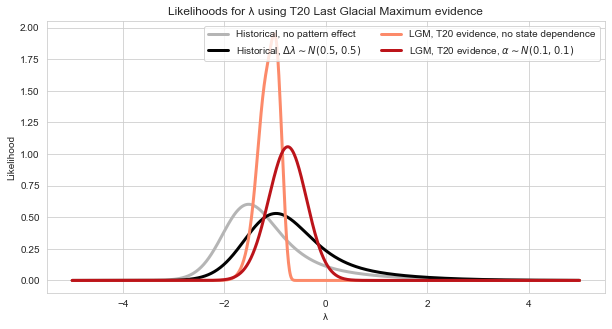

In [110]:
#plt.title("(b): Likelihoods using S20 Last Glacial Maximum evidence")

#plt.subplot(2,2,3)
plt.figure(figsize=(10,5))
lw=3
plt.plot(lams,normlam(lam_hist),\
         label=r"Historical, no pattern effect",\
         c=cm.Greys(.4),lw=lw)
plt.plot(lams,historical_patterneffect_gaussian_prior,\
         label=r"Historical, $\Delta \lambda \sim N(0.5,0.5)$",\
         c=cm.Greys(.99),lw=lw)



plt.plot(lams,normlam(alpha_0_tierney),\
         label="LGM, T20 evidence, no state dependence",\
         c=cm.Reds(.4),lw=lw)
plt.plot(lams,normlam(alpha_gaussian_tierney),\
         label=r"LGM, T20 evidence, $\alpha \sim N(0.1,0.1)$",\
         c=cm.Reds(.8),lw=lw)


plt.xlabel("λ")
plt.ylabel("Likelihood")
plt.legend(ncol=2)
plt.title("Likelihoods for λ using T20 Last Glacial Maximum evidence")

plt.savefig("FIGS/Tierney_two_towers.png")

In [111]:
M0Δλ_tierney=np.trapz(historical_patterneffect_gaussian_prior*normlam(alpha_0_tierney),x=lams)
Mα0_tierney=np.trapz(normlam(lam_hist)*normlam(alpha_gaussian_tierney),x=lams)
MαΔλ_tierney=np.trapz(historical_patterneffect_gaussian_prior*normlam(alpha_gaussian_tierney),x=lams)
M00_tierney=np.trapz(normlam(lam_hist)*normlam(alpha_0_tierney),x=lams)

In [112]:
print(Mα0_tierney/M0Δλ_tierney)

0.6664663623115622


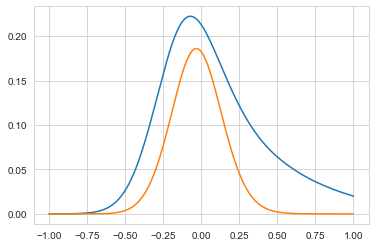

In [113]:
#Large-ish positive alpha is better at "explaining" the historical observations if you use Annan; 
tst_tierney_proc=[np.trapz(proc*JPDF_tierney[:,i],x=lams) for i in range(500)]
tst_tierney=[np.trapz(lam_hist*JPDF_tierney[:,i],x=lams) for i in range(500)]
tst_annan_proc=[np.trapz(proc*JPDF_annan[:,i],x=lams) for i in range(500)]
tst_annan=[np.trapz(lam_hist*JPDF_annan[:,i],x=lams) for i in range(500)]
plt.figure()
plt.plot(alphas,tst_tierney)
plt.plot(alphas,tst_tierney_proc)

Text(0.5, 0, 'Δλ')

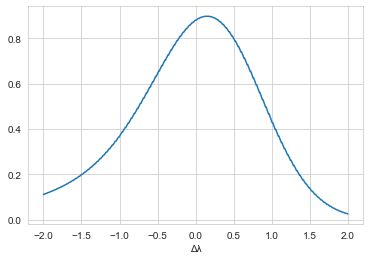

In [114]:
#and for process: most credible model is one with positive pattern effect.  But still EXTREMELY weakly constrained.≥ mnjhbv ghggfgghghfghhghnbhhnbhhhhb vv v  vvv  vb v v   v v v. b nbbb mmm,     
likelihood_proc_given_historical=[np.trapz(proc*histJPDF[:,i],x=lams) for i in range(500)]
likelihood_tierney_gaussian_given_historical=[np.trapz(alpha_gaussian_tierney*histJPDF[:,i],x=lams) for i in range(500)]
plt.figure()
plt.plot(pattern,likelihood_proc_given_historical)

plt.xlabel("Δλ")

(-2.0, 2.0)

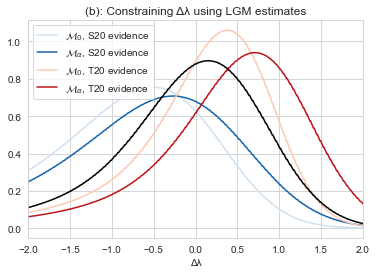

In [115]:
# invert this: how likely is LGM evidence given lambda posterior from historical?
#Given LGM data reported in S20, what is most likely model?  It's one with a negative (!!) pattern effect.  Because the S20 estimates of the LGM aren't very sensitive

likelihood_annan_0_given_historical=[np.trapz(alpha_0*histJPDF[:,i],x=lams) for i in range(500)]
likelihood_annan_gaussian_given_historical=[np.trapz(alpha_gaussian*histJPDF[:,i],x=lams) for i in range(500)]

likelihood_tierney_0_given_historical=[np.trapz(alpha_0_tierney*histJPDF[:,i],x=lams) for i in range(500)]
likelihood_tierney_gaussian_given_historical=[np.trapz(alpha_gaussian_tierney*histJPDF[:,i],x=lams) for i in range(500)]
plt.figure()
plt.plot(pattern,likelihood_annan_0_given_historical,label=r"$\mathcal{M}_0$, S20 evidence",c=cm.Blues(.2))
plt.plot(pattern,likelihood_annan_gaussian_given_historical,label=r"$\mathcal{M}_{\alpha}$, S20 evidence",c=cm.Blues(.8))
plt.plot(pattern,likelihood_tierney_0_given_historical,label=r"$\mathcal{M}_0$, T20 evidence",c=cm.Reds(.2))
plt.plot(pattern,likelihood_tierney_gaussian_given_historical,label=r"$\mathcal{M}_{\alpha}$, T20 evidence",c=cm.Reds(.8))
plt.plot(pattern,likelihood_proc_given_historical,c="k")
plt.xlabel("Δλ")
plt.title("(b): Constraining Δλ using LGM estimates")
plt.legend()
plt.xlim(-2,2)

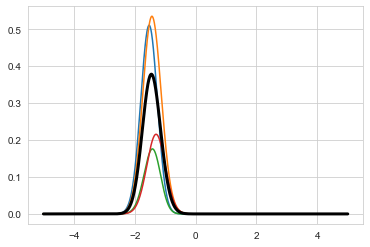

In [116]:
#lambdaprior=np.ones_like(lams)/10.
lambdaprior=proc
#ASSUMING ANNAN EVIDENCE, model averaging
P_evidence_MαΔλ=np.trapz((np.trapz(JPDF_annan*alphaprior,axis=1,x=alphas) *\
np.trapz(histJPDF*patternprior,axis=1,x=pattern))*lambdaprior,x=lams)

P_evidence_M00=np.trapz(LGM0*lam_hist*lambdaprior,x=lams)

P_evidence_M0Δλ=np.trapz((LGM0 *\
np.trapz(histJPDF*patternprior,axis=1,x=pattern))*lambdaprior,x=lams)

P_evidence_Mα0=np.trapz((np.trapz(JPDF_annan*alphaprior,axis=1,x=alphas) *\
lam_hist)*lambdaprior,x=lams)

denom=P_evidence_M00+P_evidence_M0Δλ+P_evidence_Mα0+P_evidence_MαΔλ
weight_00 = P_evidence_M00/denom
weight_0Δλ= P_evidence_M0Δλ/denom
weight_α0=P_evidence_Mα0/denom
weight_αΔλ=P_evidence_MαΔλ/denom

#Lambda posteriors from all four models
plt.figure()
#M00
M00=alpha_0*lam_hist*lambdaprior
plt.plot(lams,alpha_0*lam_hist*lambdaprior)
#Mα0
Mα0=alpha_gaussian*lam_hist*lambdaprior
plt.plot(lams,alpha_gaussian*lam_hist*lambdaprior)
#M0Δλ
M0Δλ=alpha_0*historical_patterneffect_gaussian_prior*lambdaprior
plt.plot(lams,alpha_0*historical_patterneffect_gaussian_prior*lambdaprior)
#MαΔλ
MαΔλ=alpha_gaussian*historical_patterneffect_gaussian_prior*lambdaprior
plt.plot(lams,alpha_gaussian*historical_patterneffect_gaussian_prior*lambdaprior)

model_average=weight_00*M00+weight_0Δλ*M0Δλ+weight_α0*Mα0+weight_αΔλ*MαΔλ
plt.plot(lams,model_average,c="k",lw=3)

In [117]:
alpha_gaussian_meta=normlam(np.sum(justalpha*JPDF_meta,axis=1))
S_alpha_gaussian_meta=lam_to_S(alpha_gaussian_meta)


<ipython-input-34-e26643789c9f>:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  S_results+=[integrate.quad(integrand,-np.inf,np.inf)[0]]


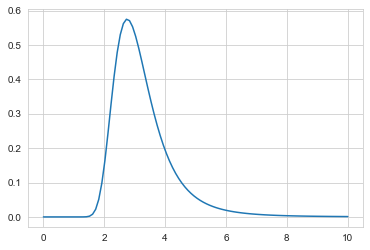

In [118]:
plt.plot(Ses,S_alpha_gaussian_meta)

In [119]:
LGM0_meta=np.array([LGM_likelihood(x,0,tempfrom="meta") for x in lams])
alpha_0_meta=normlam(LGM0_meta)
S_alpha_0_meta=lam_to_S(alpha_0_meta)

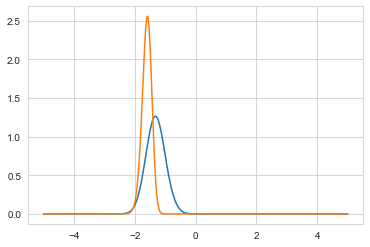

In [120]:
plt.figure()
plt.plot(lams,alpha_gaussian_meta)
plt.plot(lams,alpha_0_meta)

In [121]:
#prior_on_lambda=np.ones_like(lams)/10.
def get_BMA_S(prior_on_lambda,prior_on_alpha,prior_on_pattern):
# prior_on_alpha=alphaprior
# prior_on_pattern=patternprior
# prior_on_lambda=np.ones_like(lams)/10.

    #ASSUMING META EVIDENCE, model averaging
    P_evidence_MαΔλ=np.trapz((np.trapz(JPDF_meta*prior_on_alpha,axis=1,x=alphas) *\
    np.trapz(histJPDF*prior_on_pattern,axis=1,x=pattern))*prior_on_lambda,x=lams)

    P_evidence_M00=np.trapz(alpha_0_meta*lam_hist*prior_on_lambda,x=lams)

    P_evidence_M0Δλ=np.trapz((alpha_0_meta *\
    np.trapz(histJPDF*prior_on_pattern,axis=1,x=pattern))*prior_on_lambda,x=lams)

    P_evidence_Mα0=np.trapz((np.trapz(JPDF_meta*prior_on_alpha,axis=1,x=alphas) *\
    lam_hist)*prior_on_lambda,x=lams)

    denom=P_evidence_M00+P_evidence_M0Δλ+P_evidence_Mα0+P_evidence_MαΔλ
    weight_00 = P_evidence_M00/denom
    weight_0Δλ= P_evidence_M0Δλ/denom
    weight_α0=P_evidence_Mα0/denom
    weight_αΔλ=P_evidence_MαΔλ/denom
    print("weight 00",weight_00)
    print("weight 0Δλ",weight_0Δλ)
    print("weight α0", weight_α0)
    print("weight αΔλ",weight_αΔλ)

    #Lambda posteriors from all four models FIX THIS
    #plt.figure()
    #M00
    M00=alpha_0_meta*lam_hist*prior_on_lambda
    #plt.plot(lams,normlam(M00))
    #Mα0
    Mα0=np.trapz(JPDF_meta*prior_on_alpha,axis=1,x=alphas) *lam_hist*prior_on_lambda
    #plt.plot(lams,normlam(Mα0))
    #M0Δλ
    M0Δλ=alpha_0_meta *\
    np.trapz(histJPDF*prior_on_pattern,axis=1,x=pattern)*prior_on_lambda
    #plt.plot(lams,normlam(M0Δλ))
    #MαΔλ
    MαΔλ=np.trapz(JPDF_meta*prior_on_alpha,axis=1,x=alphas) *\
    np.trapz(histJPDF*prior_on_pattern,axis=1,x=pattern)*prior_on_lambda
    #plt.plot(lams,normlam(MαΔλ))

    model_average=weight_00*M00+weight_0Δλ*M0Δλ+weight_α0*Mα0+weight_αΔλ*MαΔλ
    return lam_to_S(model_average)

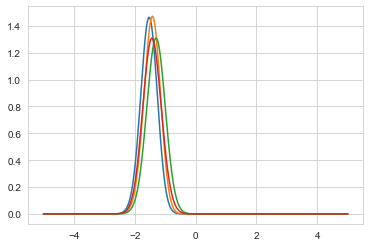

In [122]:
plt.plot(lams,normlam(M00))
plt.plot(lams,normlam(M0Δλ))
plt.plot(lams,normlam(MαΔλ))
plt.plot(lams,normlam(Mα0))

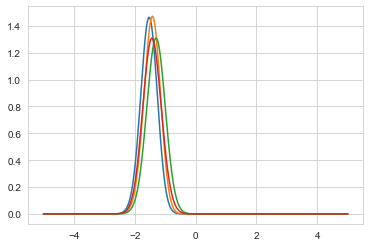

In [123]:
plt.plot(lams,normlam(M00))
plt.plot(lams,normlam(M0Δλ))
plt.plot(lams,normlam(MαΔλ))
plt.plot(lams,normlam(Mα0))

In [124]:
np.sum(np.ones_like(lams)/len(lams))

1.0000000000000004

In [125]:
Smeta=get_BMA_S(proc,alphaprior,patternprior)
Suniformlam=get_BMA_S(np.ones_like(lams)/len(lams),alphaprior,patternprior)
Suniformpatt=get_BMA_S(proc,alphaprior,np.ones_like(patternprior)/len(patternprior))
Suniformalpha=get_BMA_S(proc,np.ones_like(alphaprior)/len(alphaprior),patternprior)

weight 00 0.43775676294984894
weight 0Δλ 0.25442329814460274
weight α0 0.16842926051288293
weight αΔλ 0.13939067839266545
weight 00 0.45261965405463783
weight 0Δλ 0.25259332053586747
weight α0 0.16115072766945848
weight αΔλ 0.13363629774003624
weight 00 0.7197528659007545
weight 0Δλ 0.002320141514358592
weight α0 0.2769287723593217
weight αΔλ 0.0009982202255652591
weight 00 0.6321627752141006
weight 0Δλ 0.3674116583611586
weight α0 0.00022315585286968514
weight αΔλ 0.00020241057187127883


In [126]:
Suninformative=get_BMA_S(np.ones_like(lams)/len(lams),np.ones_like(alphaprior)/len(alphaprior),np.ones_like(patternprior)/len(patternprior))

weight 00 0.9962114151288277
weight 0Δλ 0.003250134847768559
weight α0 0.000534321127190896
weight αΔλ 4.128896212670784e-06


(0.0, 6.0)

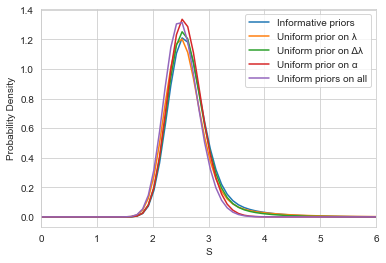

In [127]:
plt.figure()
plt.plot(Ses,normlam(Smeta,x=Ses),label="Informative priors")
plt.plot(Ses,normlam(Suniformlam,x=Ses),label="Uniform prior on λ")
plt.plot(Ses,normlam(Suniformpatt,x=Ses),label="Uniform prior on Δλ")
plt.plot(Ses,normlam(Suniformalpha,x=Ses),label="Uniform prior on α")
plt.plot(Ses,normlam(Suninformative,x=Ses),label="Uniform priors on all")
plt.ylabel("Probability Density")
plt.legend()
plt.xlabel("S")
plt.xlim(0,6)
#plt.savefig("FIGS/MetaBMA.png")

In [128]:
az.hdi(np.random.choice(Ses,1000000,p=Smeta/np.sum(Smeta)),hdi_prob=.90)

array([1.91919192, 3.13131313])

In [129]:
az.hdi(np.random.choice(Ses,1000000,p=Suninformative/np.sum(Suninformative)),hdi_prob=.90)

array([2.02020202, 2.92929293])

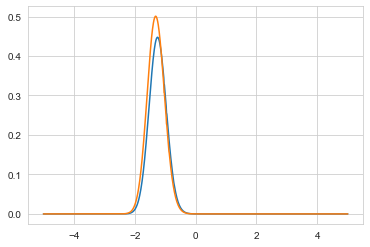

In [130]:
prior_on_alpha=alphaprior
prior_on_pattern=patternprior
tst=np.trapz(JPDF_meta*prior_on_alpha,axis=1,x=alphas) *\
    np.trapz(histJPDF*prior_on_pattern,axis=1,x=pattern)

prior_on_alpha=alphaprior
prior_on_pattern=patternprior2
tst2=np.trapz(JPDF_meta*prior_on_alpha,axis=1,x=alphas) *\
    np.trapz(histJPDF*prior_on_pattern,axis=1,x=pattern)

plt.figure()

plt.plot(lams,tst)
plt.plot(lams,tst2)

In [131]:
lam_hist

array([6.59961386e-09, 6.97064297e-09, 7.35984579e-09, 7.76826839e-09,
       8.14601091e-09, 8.77677644e-09, 7.03545508e-08, 7.51789702e-08,
       8.03326403e-08, 8.85157573e-08, 9.37195355e-08, 1.00137462e-07,
       1.06860260e-07, 1.14200444e-07, 1.22047726e-07, 1.30437205e-07,
       1.39414888e-07, 1.49003742e-07, 1.59255248e-07, 1.70215137e-07,
       1.81932582e-07, 1.94459935e-07, 2.07853255e-07, 2.22138703e-07,
       2.37361473e-07, 2.53726614e-07, 2.69751022e-07, 2.88411369e-07,
       3.08251701e-07, 3.29539870e-07, 3.52986448e-07, 3.77304641e-07,
       4.03363319e-07, 4.30783255e-07, 4.61007634e-07, 4.92866489e-07,
       5.26935136e-07, 5.63330979e-07, 6.02314199e-07, 6.44017143e-07,
       6.88498548e-07, 7.36112743e-07, 7.87022644e-07, 8.41455656e-07,
       8.99654945e-07, 9.61880224e-07, 1.02828742e-06, 1.09941584e-06,
       1.17540775e-06, 1.25670882e-06, 1.34334424e-06, 1.43655418e-06,
       1.53591670e-06, 1.64212779e-06, 1.75566402e-06, 1.87703548e-06,
      

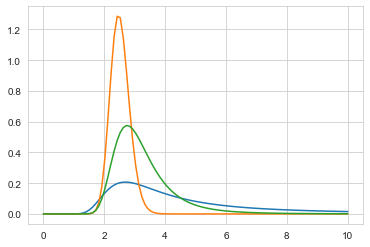

In [135]:
plt.plot(Ses,S_hist_patt)
plt.plot(Ses,S_alpha_0_meta)
plt.plot(Ses,S_alpha_gaussian_meta)
plt.plot(Ses,S_)

In [137]:
Sproc=lam_to_S(lambdaprior)

In [143]:
sns.set_style("white")

Text(0, 0.5, 'PDF')

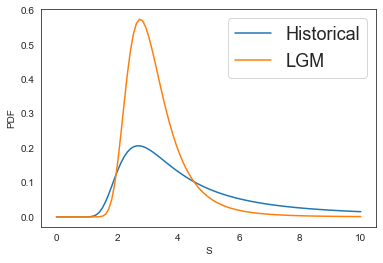

In [148]:
plt.plot(Ses,S_hist_patt,label="Historical")
plt.plot(Ses,S_alpha_gaussian_meta,label="LGM")
plt.legend(fontsize=18)
plt.xlabel("S")
plt.ylabel("PDF")